<a href="https://colab.research.google.com/github/htnphu/retail-sales-forecasting/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')
import matplotlib.dates as mdates


import gc
import logging
import warnings

warnings.filterwarnings('ignore')

In [ ]:
!pip install tabulate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/data/"
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/models/"

In [ ]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype

        if pd.api.types.is_datetime64_any_dtype(col_type):
            continue

        # only process numeric columns for min/max
        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                # this is where the error occurred previously for datetime types
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # handle categorical columns without min/max
        elif isinstance(col_type, pd.CategoricalDtype):
            df[col] = df[col].cat.as_unordered()  # ensure no ordering assumption
        else:
            df[col] = df[col].astype('category')  # convert objects to category
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased from {start_mem:.2f} Mb to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [ ]:
print("Loading and reducing memory usage for data files...")
df = pd.read_parquet(f'{DATA_PATH}final_m5_model_data.parquet')
df = reduce_mem_usage(df)
print("\nInitial data loading complete.")

Loading and reducing memory usage for data files...
Memory usage decreased from 10068.35 Mb to 6007.70 Mb (40.3% reduction)

Initial data loading complete.


In [ ]:
print(df.head().to_markdown())

|    | item_id     | dept_id   | cat_id   | store_id   | state_id   | d    |   sales |   sell_price | date                |   wday |   month |   year |   snap_CA |   snap_TX |   snap_WI | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   has_sale |   quarter |   week |   day_of_week |   day_of_month |   day_of_year |   weekend |   price_mean |   price_relative_to_mean |   price_change_lag |   sales_lag_1 |   sales_lag_7 |   sales_lag_28 |   sales_rolling_mean_7 |   sales_rolling_mean_28 |   price_lag_7 |   price_lag_28 |   month_sin |   month_cos |   day_of_month_sin |   day_of_month_cos |   day_of_week_sin |   day_of_week_cos |
|---:|:------------|:----------|:---------|:-----------|:-----------|:-----|--------:|-------------:|:--------------------|-------:|--------:|-------:|----------:|----------:|----------:|:---------------|:---------------|:---------------|:---------------|-----------:|----------:|-------:|--------------:|---------------:|--------------:|-----

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 42 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   item_id                 category      
 1   dept_id                 category      
 2   cat_id                  category      
 3   store_id                category      
 4   state_id                category      
 5   d                       category      
 6   sales                   int16         
 7   sell_price              float32       
 8   date                    datetime64[ns]
 9   wday                    int8          
 10  month                   int8          
 11  year                    int16         
 12  snap_CA                 int8          
 13  snap_TX                 int8          
 14  snap_WI                 int8          
 15  event_name_1            category      
 16  event_type_1            category      
 17  event_name_2            category      
 18  

In [ ]:
print(df.shape)

(58327370, 42)


In [ ]:
gc.collect()

71

In [ ]:
print(df.isnull().sum().to_markdown())

|                        |   0 |
|:-----------------------|----:|
| item_id                |   0 |
| dept_id                |   0 |
| cat_id                 |   0 |
| store_id               |   0 |
| state_id               |   0 |
| d                      |   0 |
| sales                  |   0 |
| sell_price             |   0 |
| date                   |   0 |
| wday                   |   0 |
| month                  |   0 |
| year                   |   0 |
| snap_CA                |   0 |
| snap_TX                |   0 |
| snap_WI                |   0 |
| event_name_1           |   0 |
| event_type_1           |   0 |
| event_name_2           |   0 |
| event_type_2           |   0 |
| has_sale               |   0 |
| quarter                |   0 |
| week                   |   0 |
| day_of_week            |   0 |
| day_of_month           |   0 |
| day_of_year            |   0 |
| weekend                |   0 |
| price_mean             |   0 |
| price_relative_to_mean |   0 |
| price_ch

## Note

1. The "Categorical Feature" Problem:

This is the most important reason. Linear models like LinearRegression and Ridge can't handle categorical features like item_id, store_id, or dept_id directly.

The technically correct way to use them is one-hot encoding but it is impossible. Because our item_id column has over 3,000 unique items. One-hot encoding it would add 3,000+ new columns to the DataFrame. Doing this for all categorical features would add thousands of columns, exploding your DataFrame from 33 features to ~3,200+ features.

So, definitely, the notebook will instantly crash from a memory explosion. (out of memory usage)

That's why tree models are the solution. They are specifically designed to handle high-cardinality categorical features without one-hot encoding, saving us from this memory crisis.

2. Linear models can only find simple, a straight-line relationships.

The Heatmap from the EDA and Feature Engineering step proved this:
- We saw that snap_CA and weekend have a 0.00 correlation with sales. A linear model will look at this 0.00 and conclude that "this feature is useless". But in reality, we know a weekend day boosts sales, and a snap day boosts food sales. So, this is a complex, non-linear rule.

Tree models are the solution here, too. They excel at finding these complex, non-linear patterns and "if-then" rules. A tree model can easily learn:

- "IF day_of_week is a weekend AND category is 'FOODS', THEN sales go up"

A linear model can never discover this rule.

Summary: We have to move to tree models because linear models can't handle your most important features (the categories) and can't understand the most important patterns (the non-linear rules).

In [ ]:
gc.collect()

0

## XGBoost

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.9/609.9 kB 60.9 MB/s eta 0:00:00


In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.2 MB/s eta 0:00:00


In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 13.2 MB/s eta 0:00:00


In [ ]:
import optuna
import shap

import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# list of all categorical features
cat_features = [
    'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'
]

# create a copy to avoid SettingWithCopyWarning
df_encoded = df.copy()

print("Encoding categorical features...")
for col in cat_features:
    # init a new LabelEncoder for each column
    encoder = LabelEncoder()
    # fit and transform the column
    df_encoded[col] = encoder.fit_transform(df_encoded[col].astype(str))

print("Encoding complete.")

Encoding categorical features...
Encoding complete.


In [ ]:
gc.collect()

0

In [ ]:
target = 'sales'

redundant_features = ['has_sale', 'date', 'd']

columns_to_drop = [target] + redundant_features

features = [col for col in df_encoded.columns if col not in columns_to_drop]

print(f"Target variable: {target}")
print(f"Total features being used: {len(features)}")

Target variable: sales
Total features being used: 38


In [ ]:
print("Sorting dataframe...")
df_encoded = df_encoded.sort_values(['item_id', 'store_id', 'date']).reset_index(drop=True)

VALID_DAYS = 28
split_date = df_encoded['date'].unique()[-VALID_DAYS]
print(f"Splitting data at date: {split_date}")

train_df = df_encoded[df_encoded['date'] < split_date].copy()
valid_df = df_encoded[df_encoded['date'] >= split_date].copy()

X_train = train_df[features]
y_train = train_df[target]

X_valid = valid_df[features]
y_valid = valid_df[target]

print(f"Training set shape:   {X_train.shape}")
print(f"Validation set shape: {X_valid.shape}")

del df_encoded
gc.collect()

Sorting dataframe...
Splitting data at date: 2016-04-25 00:00:00
Training set shape:   (57473650, 38)
Validation set shape: (853720, 38)


0

In [ ]:
gc.collect()

0

In [ ]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_jobs': -1, # -1 is for the inside of one model (safe)
        'random_state': 42,
        'tree_method': 'hist',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'n_estimators': trial.suggest_int('n_estimators', 400, 2000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1),
    }

    model = xgb.XGBRegressor(
        **params,
        early_stopping_rounds=50 # stops bad trials early
        )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    best_rmse = model.best_score
    return best_rmse


In [ ]:
# run the study
print("Starting Optuna tuning...")
study = optuna.create_study(direction='minimize', study_name="XGB_Tuning")
study.optimize(objective, n_trials=20) # will run 20 trials, one by one

[I 2025-12-06 04:13:16,276] A new study created in memory with name: XGB_Tuning


Starting Optuna tuning...


[I 2025-12-06 04:14:44,404] Trial 0 finished with value: 1.9409529460015758 and parameters: {'learning_rate': 0.12139536732101593, 'max_depth': 11, 'n_estimators': 611, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial 0 with value: 1.9409529460015758.
[I 2025-12-06 04:19:04,490] Trial 1 finished with value: 1.952993740713652 and parameters: {'learning_rate': 0.013033500673347789, 'max_depth': 8, 'n_estimators': 645, 'subsample': 1.0, 'colsample_bytree': 0.7}. Best is trial 0 with value: 1.9409529460015758.
[I 2025-12-06 04:20:21,424] Trial 2 finished with value: 1.947453579287162 and parameters: {'learning_rate': 0.16834748340700026, 'max_depth': 12, 'n_estimators': 1590, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 0 with value: 1.9409529460015758.
[I 2025-12-06 04:22:15,470] Trial 3 finished with value: 1.9460138485150908 and parameters: {'learning_rate': 0.20997903001106086, 'max_depth': 8, 'n_estimators': 1267, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best 

In [ ]:
print("\n--- Tuning Complete ---")
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial's RMSE: {study.best_value:.4f}")
print("Best parameters found:")
print(study.best_params)


--- Tuning Complete ---
Number of finished trials: 20
Best trial's RMSE: 1.9341
Best parameters found:
{'learning_rate': 0.02531581371838796, 'max_depth': 9, 'n_estimators': 1581, 'subsample': 1.0, 'colsample_bytree': 0.6}


In [ ]:
print("\nTraining final model with best parameters...")
best_params = study.best_params

print("\n--- Init final model ---")

final_model = xgb.XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    eval_metric='rmse',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=50,
)
print("\n--- Init final model completed---")


Training final model with best parameters...

--- Init final model ---

--- Init final model completed---


In [ ]:
print("\n--- Training final model ---")

final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

print("\n--- Training final model completed ---")


--- Training final model ---

--- Training final model completed ---


In [ ]:
valid_preds_xgb_tuned = final_model.predict(X_valid)

In [ ]:
rmse_xgb = np.sqrt(mean_squared_error(y_valid, valid_preds_xgb_tuned))
mse_xgb = mean_squared_error(y_valid, valid_preds_xgb_tuned)
mae_xgb = mean_absolute_error(y_valid, valid_preds_xgb_tuned)

print(f"\nTuned XGBoost Validation RMSE: {rmse_xgb:.4f}")
print(f"Tuned XGBoost Validation MSE: {mse_xgb:.4f}")
print(f"Tuned XGBoost Validation MAE: {mae_xgb:.4f}")

results = {
    "Model": ["Tuned XGBoost"],
    "RMSE": [rmse_xgb],
    "MSE": [mse_xgb],
    "MAE": [mae_xgb],
}
results_df = pd.DataFrame(results).set_index("Model")

print("\n--- Summary of All Metrics ---")
print(results_df.round(4))


Tuned XGBoost Validation RMSE: 1.9341
Tuned XGBoost Validation MSE: 3.7407
Tuned XGBoost Validation MAE: 0.9872

--- Summary of All Metrics ---
                 RMSE     MSE     MAE
Model                                
Tuned XGBoost  1.9341  3.7407  0.9872


In [ ]:
gc.collect()

47

In [ ]:
print("Saving model...")
final_model.save_model(f'{MODEL_PATH}final_m5_model_xgb_tuned.json')
print("\n Model saved successfully...")


Saving model...

 Model saved successfully...


In [ ]:
print("Creating background data sample from X_train...")
X_train_sample = shap.sample(X_train, 1000, random_state=42)

# --- Create the TreeExplainer ---
# We use TreeExplainer because we have an XGBoost model.
# We pass the final, tuned model and our background sample.
print("Initializing SHAP TreeExplainer...")
explainer = shap.TreeExplainer(final_model, X_train_sample)

Creating background data sample from X_train...
Initializing SHAP TreeExplainer...


In [ ]:
# create a sample of your validation set to analyze ---
# 2000 rows is a good size for plotting.
print("Creating sample from X_valid to analyze...")
X_valid_sample = X_valid.sample(2000, random_state=42)

# calculate SHAP values for the validation sample ---
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_valid_sample)

print("SHAP values calculated.")

Creating sample from X_valid to analyze...
Calculating SHAP values...


100%|===================| 1991/2000 [02:14<00:00]       

SHAP values calculated.


Global Importance (Bar Plot)
This plot will look similar to your old "Gain" plot, but it's much more accurate. It's the average impact of each feature

Generating Global Importance plot (Bar)...


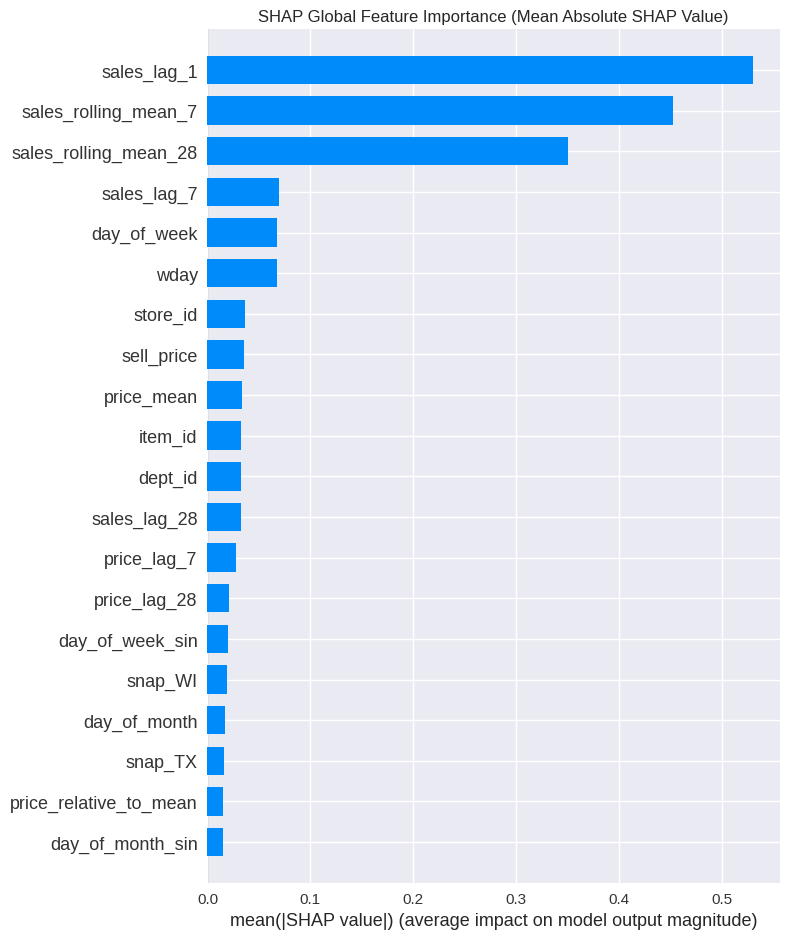

<Figure size 800x550 with 0 Axes>

In [ ]:
print("Generating Global Importance plot (Bar)...")
plt.figure()
plt.title("SHAP Global Feature Importance (Mean Absolute SHAP Value)")
shap.summary_plot(shap_values, X_valid_sample, plot_type="bar")
plt.savefig('shap_global_importance.png')

Summary Plot (Beeswarm Plot)
This is the most powerful plot. It shows the importance, impact, and the original value all at once.

When the 7-day rolling mean was high (red), it strongly increased the sales prediction. When the rolling mean was low (blue), it strongly decreased the prediction.

Generating Summary plot (Beeswarm)...


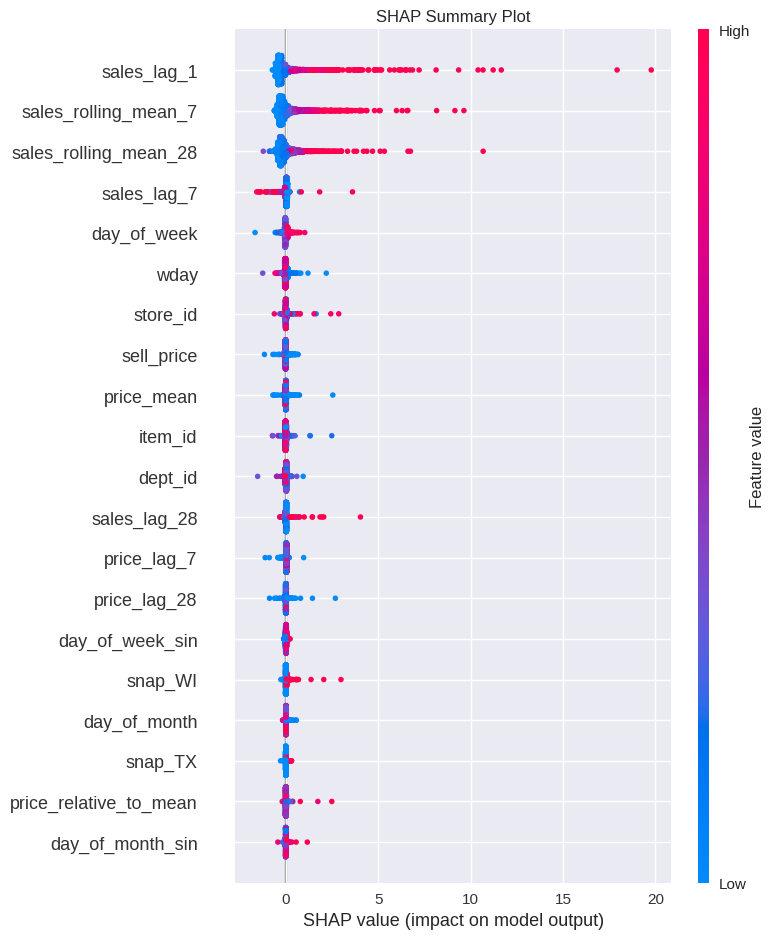

<Figure size 800x550 with 0 Axes>

In [ ]:
print("Generating Summary plot (Beeswarm)...")
plt.figure(figsize=(18, 10))
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_valid_sample)
plt.tight_layout()
plt.savefig('shap_summary_plot.png')
# plt.show()

 99%|===================| 1985/2000 [02:13<00:01]       


Generating Waterfall plot for one prediction...


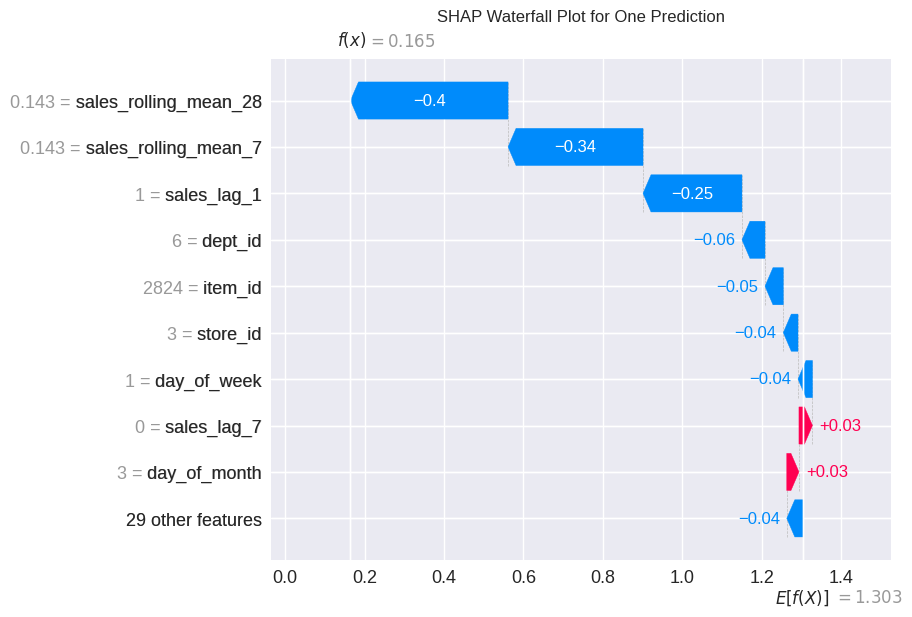

<Figure size 800x550 with 0 Axes>

In [ ]:
shap_explanation = explainer(X_valid_sample)

print("\nGenerating Waterfall plot for one prediction...")
plt.figure()
plt.title("SHAP Waterfall Plot for One Prediction")
shap.waterfall_plot(shap_explanation[0])
plt.savefig('shap_waterfall_plot.png')
plt.show()

In [ ]:
gc.collect()

29091